# Rmax prediction of 6-helicenes from neural networks models

Linear and non-linear models have been built for regression of Rmax from a dataset of 6-helicenes with up to 4 halogens (F,Cl,Br,I) elements replacing the hydrogen atoms. 

The fundamental 6-helicene is made of 6 carbon rings with 16 bonding hydrogens. For the neural network model, each molecule is represented by a 16-component vector, each component associated to the position of one hydrogen. For example, a 6-helicene with a Fl atom in the position of the 4th hydrogen and a Br atom in the position of the 8th hydrogen atom is represented as:

$$(H,H,H,Cl,H,H,H,Br,H,H,H,H,H,H,H,H)$$


The models respect specular symmetry with respect to the middle of the molecule, which means that for the model:

$$(H,H,H,Cl,H,H,H,Br,H,H,H,H,H,H,H,H) = (H,H,H,H,H,H,H,H,Br,H,H,H,Cl,H,H,H)$$

In [1]:
# Load libraries

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.special

tf.__version__

2023-05-24 15:09:44.367104: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 15:09:44.588343: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-24 15:09:45.284435: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-24 15:09:45.284489: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

'2.11.0'

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#!ls "/content/drive/MyDrive"
#!pwd
#working_dir = '/content/drive/MyDrive/Colab_Notebooks/Rmax_prediction_6Helicenes'
working_dir = '.'

In [4]:
# Load pre-trained model

# model = tf.keras.models.load_model('./Models/R_model_invariant_linear')
# model.summary()

linear_model = tf.keras.models.load_model(working_dir+'/Models/R_model_invariant_linear')
non_linear_model = tf.keras.models.load_model(working_dir+'/Models/R_model_invariant_non-linear_many-body_dropout')

#print(linear_model.summary())
print(non_linear_model.summary())

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Pos_1 (InputLayer)             [(None, 5)]          0           []                               
                                                                                                  
 Pos_2 (InputLayer)             [(None, 5)]          0           []                               
                                                                                                  
 Pos_3 (InputLayer)             [(None, 5)]          0           []                               
                                                                                                  
 Pos_4 (InputLayer)             [(None, 5)]          0           []                               
                                                                                           

In [4]:
# Auxiliar tools to define input molecules of the model

#x_int = np.zeros(16)
n_pos = 16
x0_int = [0]*n_pos
x0_str =['H']*n_pos
#print('Fundamental 6-helicene:')
#print(x0_int)
#print(x0_str)

# dictionary to convert integer representation to string representation
int2str = {
  "0": "H",
  "1": "Fl",
  "2": "Cl",
  "3": "Br",
  "4": "I"
}

# dictionary to convert string representation to integer representation
str2int = {
  "H": "0",
  "Fl": "1",
  "Cl": "2",
  "Br": "3",
  "I": "4"
}

# function to convert integer representation to string representation
def int_to_str(x_int):
  x_str = [int2str[str(int(k))] for k in x_int]
  return x_str

# function to convert string representation to integer representation
def str_to_int(x_str):
  x_int = [int(str2int[c]) for c in x_str]
  return x_int

# One-hot encode input features
n_atom_types = 5 # there are 5 atom types: hydrogen and 4 halogens
n_features = n_atom_types*n_pos

# functions to define one-hot encoded vector being input of the model
def int_to_ohe(x_int):
  x_ohe = np.zeros(n_features) 
  for j in range(n_pos):
    atom_id = x_int[j]
    x_ohe[j*n_atom_types+atom_id] = 1.0
  return x_ohe

def str_to_ohe(x_str):
  #x_int = [int_to_str[str(k)] for k in x_str]
  x_int = str_to_int(x_str)
  print(x_int)
  x_ohe = np.zeros(n_features) 
  for j in range(n_pos):
    atom_id = x_int[j]
    x_ohe[j*n_atom_types+atom_id] = 1.0
  return x_ohe

# function to reshape the input as (1,n_features) and split it into multiple inputs
# The model architecture is designed to respect symmetries
def int_to_input(x_int):
  x_input = np.zeros((1,n_features))
  x_ohe = int_to_ohe(x_int)
  x_input[0,:] = x_ohe[:]
  x_input = np.split(x_input,n_pos,axis=1)
  return x_input

def str_to_input(x_str):
  x_input = np.zeros((1,n_features))
  x_int = str_to_int(x_str)
  x_ohe = int_to_ohe(x_int)
  x_input[0,:] = x_ohe[:]
  x_input = np.split(x_input,n_pos,axis=1)
  return x_input

""" # Examples
print()
x_int = x0_int
x_int[2] = 3
#x_str2 = [int2str[str(k)] for k in x_int]
x_str2 = int_to_str(x_int)
print(x_str2)
x_ohe2 = int_to_ohe(x_int)
print(x_ohe2)

print()
x_str = x0_str
x_str[2] = 'Br'
#x_str2 = [int2str[str(k)] for k in x_int]
x_int2 = str_to_int(x_str)
print(x_int2)
x_ohe2 = int_to_ohe(x_int2)
print(x_ohe2)

# Rmax calculation example (integer representation)
n_data = 1
x_input = np.zeros((n_data,n_features))
x = x0_int.copy()
x[2] = 3
x_ohe = int_to_ohe(x)
print(x)
print(x_ohe)
x_input[0,:] = x_ohe[:]
x_input = np.split(x_input,n_pos,axis=1)
#print(x_input)
Rmax = model.predict(x_input)
Rmax = float(Rmax)
print(Rmax) 

# Example of molecule with integer representation
x = x0_int.copy()
x[2] = 3
x_input = int_to_input(x)
print(float(model.predict(x_input))) """


" # Examples\nprint()\nx_int = x0_int\nx_int[2] = 3\n#x_str2 = [int2str[str(k)] for k in x_int]\nx_str2 = int_to_str(x_int)\nprint(x_str2)\nx_ohe2 = int_to_ohe(x_int)\nprint(x_ohe2)\n\nprint()\nx_str = x0_str\nx_str[2] = 'Br'\n#x_str2 = [int2str[str(k)] for k in x_int]\nx_int2 = str_to_int(x_str)\nprint(x_int2)\nx_ohe2 = int_to_ohe(x_int2)\nprint(x_ohe2)\n\n# Rmax calculation example (integer representation)\nn_data = 1\nx_input = np.zeros((n_data,n_features))\nx = x0_int.copy()\nx[2] = 3\nx_ohe = int_to_ohe(x)\nprint(x)\nprint(x_ohe)\nx_input[0,:] = x_ohe[:]\nx_input = np.split(x_input,n_pos,axis=1)\n#print(x_input)\nRmax = model.predict(x_input)\nRmax = float(Rmax)\nprint(Rmax) \n\n# Example of molecule with integer representation\nx = x0_int.copy()\nx[2] = 3\nx_input = int_to_input(x)\nprint(float(model.predict(x_input))) "

In [5]:
# Auxiliar function to evaluate Rmax with original units

R_mean = 591.451949
R_std = 85.381995

def calculate_Rmax(x,rep,mod):
    if(rep=='int'): # integer represenation of the input vector
        x_input = int_to_input(x)
    elif(rep=='str'): # string represenation of the input vector
        x_input = str_to_input(x)
    if(mod=='linear'):
        model = linear_model
    elif(mod=='non_linear'):
        model = non_linear_model
    Rmax = float( model.predict(x_input) )
    Rmax = Rmax * R_std + R_mean
    return Rmax

In [6]:
# Examples 

print('Fundamental 6-helicene:')
print(x0_int)
print(x0_str)

# Note: x[] indexes range from 0 to 15 for the 16 components, as usual in Python

# Example of molecule with integer representation: (0,1,2,3,4) for (H,F,Cl,Br,I)
x = x0_int.copy()
x[5] = 3
Rmax = calculate_Rmax(x,rep='int',mod='linear')
print()
print('Br in 5th position:')
print(x)
print(Rmax)

# Example of molecule with string representation
x = x0_str.copy()
x[5] = 'Br'
Rmax = calculate_Rmax(x,rep='str',mod='linear')
print()
print('Br in 5h position:')
print(x)
print(Rmax)

x = x0_str.copy()
x[10] = 'Br'
Rmax = calculate_Rmax(x,rep='str',mod='linear')
print()
print('Br in 10 position:')
print(x)
print(Rmax)

x = x0_str.copy()
x[10] = 'Br'
Rmax = calculate_Rmax(x,rep='str',mod='non_linear')
print()
print('Br in 10 position, non-linear model:')
print(x)
print(Rmax)



Fundamental 6-helicene:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
1/1 [==============================] - 0s 81ms/step

Br in 5th position:
[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
647.6140233073165
1/1 [==============================] - 0s 20ms/step

Br in 5h position:
['H', 'H', 'H', 'H', 'H', 'Br', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
647.6140233073165
1/1 [==============================] - 0s 20ms/step

Br in 10 position:
['H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'Br', 'H', 'H', 'H', 'H', 'H']
647.6140233073165
1/1 [==============================] - 0s 78ms/step

Br in 10 position, non-linear model:
['H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'Br', 'H', 'H', 'H', 'H', 'H']
610.7963250542597


In [7]:
# Define input vectors with integer representation

n_halogens = 4
def possible_molecules(npos,k):

    # n_k = binom(16, k) * 4^k / 2
    # The 1/2 factor, accounting for the specular simmetry, is ignored when analyzed the data. 
    # The only effect is that each molecule is being analyzed twice

    #n_comb = scipy.special.binom(npos, k) * n_halogens**k / 2
    n_comb = scipy.special.binom(npos, k) * n_halogens**k 

    return int(n_comb)

n1 = possible_molecules(n_pos,1)
n2 = possible_molecules(n_pos,2)
n3 = possible_molecules(n_pos,3)
n4 = possible_molecules(n_pos,4)
n_data = n1+n2+n3+n4

x_data = np.zeros((n_data,n_pos))
#n_subs = np.zeros(n_data) 
#r_cm = np.zeros(n_data) # center of the substituents
#rms_distance = np.zeros(n_data) # mean distance among substituents

# Define by number of sustituents

i_data = 0

# n1
n_comb = 0
for ipos in range(n_pos): # (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15)
    for iat in range(1,4+1): # (1,2,3,4)
        x_data[i_data,ipos] = iat
        i_data = i_data + 1
        n_comb = n_comb + 1

print(n1)
print(n_comb)

# n2
n_comb = 0
for ipos in range(n_pos): # (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15)
    for iat in range(1,4+1): # (1,2,3,4)
        for jpos in range(ipos+1,n_pos):
            for jat in range(1,4+1):
                x_data[i_data,ipos] = iat
                x_data[i_data,jpos] = jat
                i_data = i_data + 1
                n_comb = n_comb + 1
print()
print(n2)
print(n_comb)

# n3
n_comb = 0
for ipos in range(n_pos): # (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15)
    for iat in range(1,4+1): # (1,2,3,4)
        for jpos in range(ipos+1,n_pos):
            for jat in range(1,4+1):
                for kpos in range(jpos+1,n_pos):
                    for kat in range(1,4+1):
                        x_data[i_data,ipos] = iat
                        x_data[i_data,jpos] = jat
                        x_data[i_data,kpos] = kat
                        i_data = i_data + 1
                        n_comb = n_comb + 1
print()
print(n3)
print(n_comb)

# n4
n_comb = 0
for ipos in range(n_pos): # (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15)
    for iat in range(1,4+1): # (1,2,3,4)
        for jpos in range(ipos+1,n_pos):
            for jat in range(1,4+1):
                for kpos in range(jpos+1,n_pos):
                    for kat in range(1,4+1):
                        for lpos in range(kpos+1,n_pos):    
                            for lat in range(1,4+1):
                                x_data[i_data,ipos] = iat
                                x_data[i_data,jpos] = jat
                                x_data[i_data,kpos] = kat
                                x_data[i_data,lpos] = lat
                                i_data = i_data + 1
                                n_comb = n_comb + 1
print()
print(n4)
print(n_comb)

64
64

1920
1920

35840
35840

465920
465920


In [8]:
# Compute different properties of the molecules in integer representation

#mu_type = np.zeros((n_data,n_halogens)) # center of the substituents of each type

def compute_properties(x_int):

    # x_int of shape (n_molecules,16)

    n_molecules = x_int.shape[0]
    n_comp = x_int.shape[1]

    n_subs = np.zeros( n_molecules ) # number of substituents
    r_cm = np.zeros( n_molecules ) # center of the substituents of each type
    rms = np.zeros(n_molecules) # rms distance among substituents
    n_subs_type = np.zeros( (n_molecules,n_halogens+1) ) # number of substituents of each type                                                        
    r_cm_type = np.zeros((n_data,n_halogens+1)) # center of the substituents of each type
    d0 = np.zeros(n_molecules) # distance to the medium position (7.5)
    
    c_symmetry = np.zeros(n_molecules) # symmetry coefficient 
    x_left = np.zeros(8)
    x_right = np.zeros(8)
    
    # halogen-type properties are saved in [:,1], [:,2], [:,3] and [:,4] for F,Cl,Br,I respectively

    for i in range(n_molecules):
        for j in range(n_comp):
            if (x_int[i,j]>0): 
                n_subs[i] = n_subs[i] + 1   
                r_cm[i] = r_cm[i] + j      
                n_subs_type[i,int(x_int[i,j])] = n_subs_type[i,int(x_int[i,j])] + 1
                r_cm_type[i,int(x_int[i,j])] = r_cm_type[i,int(x_int[i,j])] + j
                d0[i] = d0[i] + np.abs(j-7.5)

                for k in range(j+1,n_comp):
                    if(x_int[i,k]>0): 
                        rms[i] = rms[i] + (j-k)**2        
                        #rms[i] = rms[i] + np.abs(j-k)

        x_left = x_int[i,0:8].copy()
        x_right = x_int[i,8:16].copy()
        condition_left = x_left > 0
        x_left[ condition_left ] = 1
        condition_rigth = x_right > 0
        x_right[ condition_rigth ] = 1
        x_right = np.flip(x_right)
        x_diff1 = x_left - x_right

        x_left = np.add.reduceat( x_left, np.arange(0,len(x_left),3) )
        x_right = np.add.reduceat( x_right, np.arange(0,len(x_right),3) )
        x_diff2 = x_left - x_right

        c_symmetry[i] = np.linalg.norm(x_diff1) + np.linalg.norm(x_diff2)
        
    #r_cm = r_cm / n_subs / (n_comp-1) # r_cm in [0,1]
    r_cm = r_cm / n_subs
    d0 = d0 / n_subs
    n_pairs = n_subs * (n_subs-1) / 2 # number of pairs of n_subs elements
    for i in range(n_molecules):
        if(n_pairs[i]>0):
            rms[i] = np.sqrt(rms[i]/n_pairs[i])
            #rms[i] = rms[i]/n_pairs[i]

    for i in range(n_molecules):
        for j in range(1,n_halogens+1):
            if(n_subs_type[i,j]>0):
                r_cm_type[i] = r_cm_type[i] / n_subs_type[i,j] / (n_comp-1) # r_cm in [0,1]            

    return n_subs, r_cm, rms, n_subs_type, r_cm_type, d0, c_symmetry
    #return n_subs, mu, distance, mu_type, n_subs_type

n_subs, r_cm, rms, n_subs_type, r_cm_type, d0, c_symmetry = compute_properties(x_data)

print(np.min(n_subs))
print(np.max(n_subs))
print(np.min(r_cm))
print(np.max(r_cm))
print(np.min(d0))
print(np.max(d0))
print(np.min(rms))
print(np.max(rms))
print(np.min(c_symmetry))
print(np.max(c_symmetry))

1.0
4.0
0.0
15.0
0.5
7.5
0.0
15.0
0.0
5.16227766016838


In [9]:
x_test = x_data[100,:]
print(x_test)

x_left = x_test[0:8].copy()
x_right = x_test[8:16].copy()
print(x_left)
print(x_right)
condition_left = x_left > 0
x_left[ condition_left ] = 1
condition_rigth = x_right > 0
x_right[ condition_rigth ] = 1
x_right = np.flip(x_right)
print(x_right)
x_diff1 = x_left - x_right
print(x_diff1)
print(np.linalg.norm(x_diff1))

x_left = np.add.reduceat( x_left, np.arange(0,len(x_left),3) )
x_right = np.add.reduceat( x_right, np.arange(0,len(x_right),3) )
print()
print(x_left)
print(x_right)
x_diff2 = x_left - x_right
print(np.linalg.norm(x_diff2))

csymmetry = np.linalg.norm(x_diff1) + np.linalg.norm(x_diff2)
print(csymmetry)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0.]
[ 1.  0.  0.  0.  0. -1.  0.  0.]
1.4142135623730951

[1. 0. 0.]
[0. 1. 0.]
1.4142135623730951
2.8284271247461903


In [10]:
# Convert to one-hot encode representation

def ohe(x_data):
  x_ohe = np.zeros((x_data.shape[0],n_features))
  for i in range(x_data.shape[0]):
    for j in range(n_pos):
        atom_id = int(x_data[i,j])
        x_ohe[i,j*n_atom_types+atom_id] = 1.0
  return x_ohe

x_ohe = ohe(x_data)
print(x_ohe[4000,:])

[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0.]


In [11]:
# Compute Rmax of each molecule

x_input = np.split(x_ohe,n_pos,axis=1)
#R_pred = linear_model.predict(x_input)
R_pred = non_linear_model.predict(x_input)
R_pred = R_pred * R_std + R_mean
R_pred = R_pred.ravel()
print(R_pred.shape)

15742/15742 [==============================] - 14s 902us/step
(503744,)


536.6274
87.06691
897.26874
87.171265


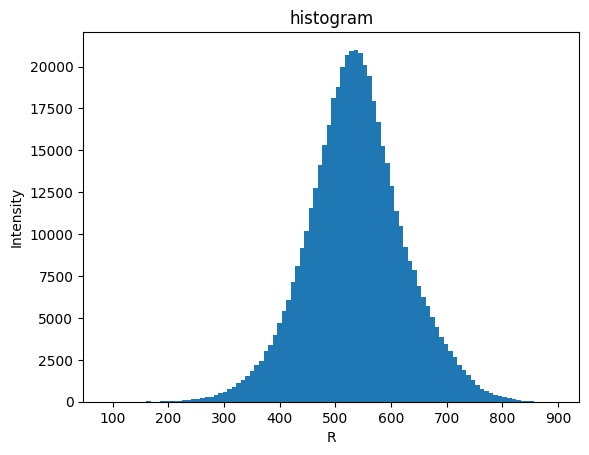

In [12]:
# Distribution of R

print(np.mean(R_pred))
print(np.std(R_pred))
print(np.max(R_pred))
print(np.min(R_pred))

plt.hist(R_pred, bins = 100) 
plt.title("histogram") 
plt.xlabel('R')
plt.ylabel('Intensity')
plt.show()

[[ 1.00000000e+00 -1.18771274e-01  2.60840155e-02  1.38627727e-01
   9.86615612e-02  4.25728412e-02  1.37842364e-02 -1.94373188e-01
   9.82052087e-02 -6.54097304e-02]
 [-1.18771274e-01  1.00000000e+00  1.13210282e-16  3.94840364e-02
   8.28368427e-02  8.28368427e-02  8.28368427e-02  8.28368427e-02
  -7.24730507e-16  9.47620616e-02]
 [ 2.60840155e-02  1.13210282e-16  1.00000000e+00  4.18693206e-16
  -3.65436779e-18  3.24832692e-18 -6.79337602e-18 -2.52370015e-17
  -3.70805796e-17 -8.32287123e-16]
 [ 1.38627727e-01  3.94840364e-02  4.18693206e-16  1.00000000e+00
   3.27073291e-03  3.27073291e-03  3.27073291e-03  3.27073291e-03
   7.33425309e-01 -3.09800031e-01]
 [ 9.86615612e-02  8.28368427e-02 -3.65436779e-18  3.27073291e-03
   1.00000000e+00 -3.24184077e-01 -3.24184077e-01 -3.24184077e-01
  -5.59420259e-17  7.84978999e-03]
 [ 4.25728412e-02  8.28368427e-02  3.24832692e-18  3.27073291e-03
  -3.24184077e-01  1.00000000e+00 -3.24184077e-01 -3.24184077e-01
  -1.38684697e-16  7.84978999e-03

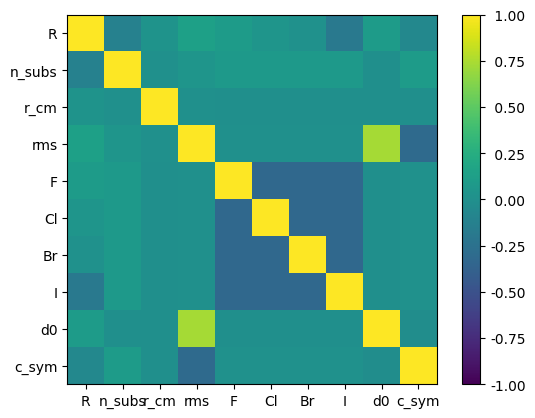

In [13]:
# See correlations of R with number of sustituents, type of sustituents, position (middle, extreme),...

# Correlation matrix 

#x = np.zeros( (n_data, 4) ) # set of variables and observations
x = np.zeros( (n_data, 10) ) # set of variables and observations

x[:,0] = R_pred[:]
x[:,1] = n_subs[:]
x[:,2] = r_cm[:]
x[:,3] = rms[:]
x[:,4] = n_subs_type[:,1] # F
x[:,5] = n_subs_type[:,2] # Cl
x[:,6] = n_subs_type[:,3] # Br
x[:,7] = n_subs_type[:,4] # I
x[:,8] = d0
x[:,9] = c_symmetry

R2 = np.corrcoef(x,rowvar=False)
print(R2)

fig, ax = plt.subplots()
#im = ax.imshow(corr_matrix)
im = ax.imshow(R2)
im.set_clim(-1, 1)
ax.grid(False)
#ax.xaxis.set(ticks=(0, 1, 2, 3), ticklabels=('R', 'n_subs', 'r_cm', 'rms'))
#ax.yaxis.set(ticks=(0, 1, 2, 3), ticklabels=('R', 'n_subs', 'r_cm', 'rms'))
ax.xaxis.set(ticks=(0, 1, 2, 3,4,5,6,7,8,9), ticklabels=('R', 'n_subs', 'r_cm', 'rms', 'F', 'Cl', 'Br', 'I', 'd0','c_sym'))
ax.yaxis.set(ticks=(0, 1, 2, 3,4,5,6,7,8,9), ticklabels=('R', 'n_subs', 'r_cm', 'rms', 'F', 'Cl', 'Br', 'I', 'd0','c_sym'))
#ax.set_ylim(2.5, -0.5)
#for i in range(4):
    #for j in range(4):
        #ax.text(j, i, corr_matrix[i, j], ha='center', va='center',
        #        color='r')
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.show()

(503744,)
(503744,)


Text(0, 0.5, 'R_pred')

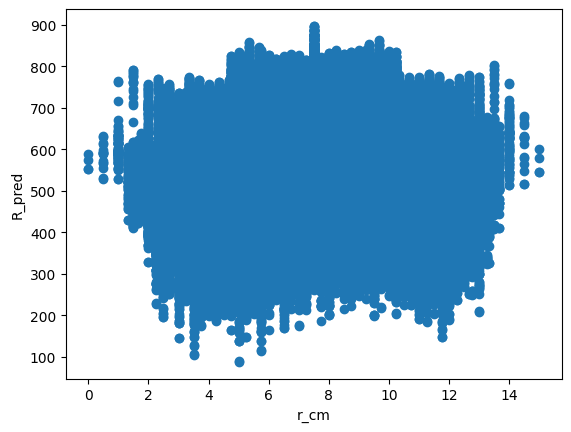

In [14]:
print(n_subs.shape)
print(n_subs.shape)
plt.scatter(r_cm,R_pred)
plt.xlabel('r_cm')
plt.ylabel('R_pred')

(503744,)
(503744,)


Text(0, 0.5, 'R_pred')

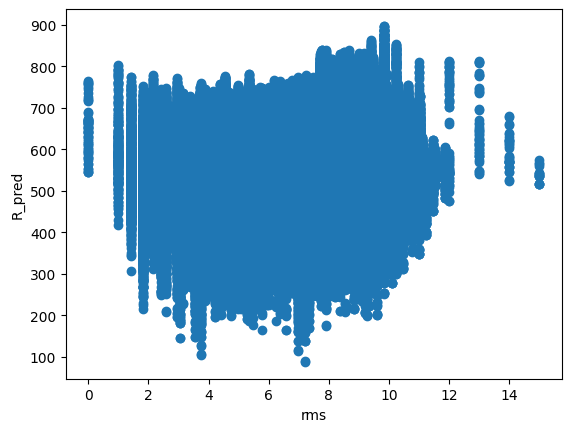

In [15]:
print(n_subs.shape)
print(n_subs.shape)
plt.scatter(rms,R_pred)
plt.xlabel('rms')
plt.ylabel('R_pred')

In [16]:
# All
print('Mean and std')
print()
print('All molecules:')
print('R_pred: '+str(np.mean(R_pred))+'  '+str(np.std(R_pred)))
print('n_subs: '+str(np.mean(n_subs))+'  '+str(np.std(n_subs)))
print('r_cm: '+str(np.mean(r_cm))+'  '+str(np.std(r_cm)))
print('rms: '+str(np.mean(rms))+'  '+str(np.std(rms)))
print('F: '+str(np.mean(n_subs_type[:,1]))+'  '+str(np.std(n_subs_type[:,1])))
print('Cl: '+str(np.mean(n_subs_type[:,2]))+'  '+str(np.std(n_subs_type[:,2])))
print('Br: '+str(np.mean(n_subs_type[:,3]))+'  '+str(np.std(n_subs_type[:,3])))
print('I: '+str(np.mean(n_subs_type[:,4]))+'  '+str(np.std(n_subs_type[:,4])))
print('d0: '+str(np.mean(d0))+'  '+str(np.std(d0)))
print('c_sym: '+str(np.mean(c_symmetry))+'  '+str(np.std(c_symmetry)))

# High Rmax
x_data_800 = x_data[ R_pred>800 ]
R_pred_800 = R_pred[ R_pred>800 ]
n_subs_800 = n_subs[ R_pred>800 ]
r_cm_800 = r_cm[ R_pred>800 ]
rms_800 = rms[ R_pred>800 ]
d0_800 = d0[ R_pred>800 ]
n_subs_type_800 = n_subs_type[ R_pred>800 ]
c_sym_800 = c_symmetry[ R_pred>800 ]

print()
print('Molecules with R>800:')
#print(x_data_800.shape)
print('R_pred: '+str(np.mean(R_pred_800))+'  '+str(np.std(R_pred_800)))
print('n_subs: '+str(np.mean(n_subs_800))+'  '+str(np.std(n_subs_800)))
print('r_cm: '+str(np.mean(r_cm_800))+'  '+str(np.std(r_cm_800)))
print('rms: '+str(np.mean(rms_800))+'  '+str(np.std(rms_800)))
print('F: '+str(np.mean(n_subs_type_800[:,1]))+'  '+str(np.std(n_subs_type_800[:,1])))
print('Cl: '+str(np.mean(n_subs_type_800[:,2]))+'  '+str(np.std(n_subs_type_800[:,2])))
print('Br: '+str(np.mean(n_subs_type_800[:,3]))+'  '+str(np.std(n_subs_type_800[:,3])))
print('I: '+str(np.mean(n_subs_type_800[:,4]))+'  '+str(np.std(n_subs_type_800[:,4])))
print('d0: '+str(np.mean(d0_800))+'  '+str(np.std(d0_800)))
print('c_sym: '+str(np.mean(c_sym_800))+'  '+str(np.std(c_sym_800)))

# Low Rmax
Rlow = 300
x_data_low = x_data[ R_pred<Rlow ]
R_pred_low = R_pred[ R_pred<Rlow ]
n_subs_low = n_subs[ R_pred<Rlow ]
r_cm_low = r_cm[ R_pred<Rlow ]
rms_low = rms[ R_pred<Rlow ]
d0_low = d0[ R_pred<Rlow ]
n_subs_type_low = n_subs_type[ R_pred<Rlow ]
c_sym_low = c_symmetry[ R_pred<Rlow ]

print()
print('Molecules with R<300:')
#print(x_data_800.shape)
print('R_pred: '+str(np.mean(R_pred_low))+'  '+str(np.std(R_pred_low)))
print('n_subs: '+str(np.mean(n_subs_low))+'  '+str(np.std(n_subs_low)))
print('r_cm: '+str(np.mean(r_cm_low))+'  '+str(np.std(r_cm_low)))
print('rms: '+str(np.mean(rms_low))+'  '+str(np.std(rms_low)))
print('F: '+str(np.mean(n_subs_type_low[:,1]))+'  '+str(np.std(n_subs_type_low[:,1])))
print('Cl: '+str(np.mean(n_subs_type_low[:,2]))+'  '+str(np.std(n_subs_type_low[:,2])))
print('Br: '+str(np.mean(n_subs_type_low[:,3]))+'  '+str(np.std(n_subs_type_low[:,3])))
print('I: '+str(np.mean(n_subs_type_low[:,4]))+'  '+str(np.std(n_subs_type_low[:,4])))
print('d0: '+str(np.mean(d0_low))+'  '+str(np.std(d0_low)))
print('c_sym: '+str(np.mean(c_sym_low))+'  '+str(np.std(c_sym_low)))

Mean and std

All molecules:
R_pred: 536.6274  87.06691
n_subs: 3.920848685046373  0.2850817353510347
r_cm: 7.5  2.0995588460941366
rms: 6.446129964622143  1.9429313609330219
F: 0.9802121712615932  0.8603712008113806
Cl: 0.9802121712615932  0.8603712008113806
Br: 0.9802121712615932  0.8603712008113807
I: 0.9802121712615932  0.8603712008113806
d0: 4.0  1.0435859800675689
c_sym: 3.365451293829274  0.9345394336487705

Molecules with R>800:
R_pred: 819.52234  18.17072
n_subs: 3.8507972665148062  0.39566909668304506
r_cm: 7.690964312832194  1.534941047970953
rms: 8.801166393782944  0.977725396137235
F: 0.571753986332574  0.5039474007845042
Cl: 0.5808656036446469  0.6713792132594256
Br: 1.2118451025056947  0.8881636316574899
I: 1.4863325740318907  0.8559958638961228
d0: 5.317388003037205  0.5785945810678135
c_sym: 2.181433844572704  1.0983606710194334

Molecules with R<300:
R_pred: 265.644  31.369932
n_subs: 3.9931034482758623  0.08275862068965519
r_cm: 7.042145593869732  2.801659035822206
r

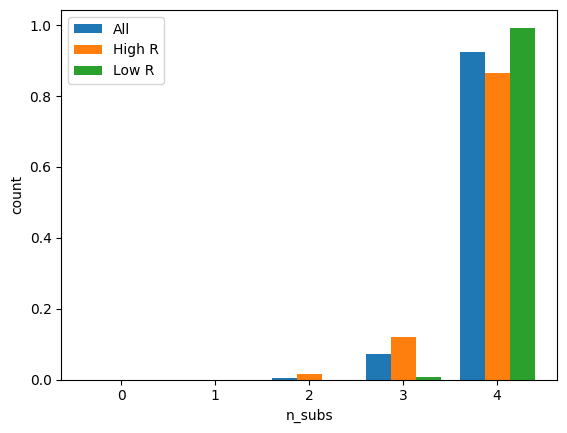

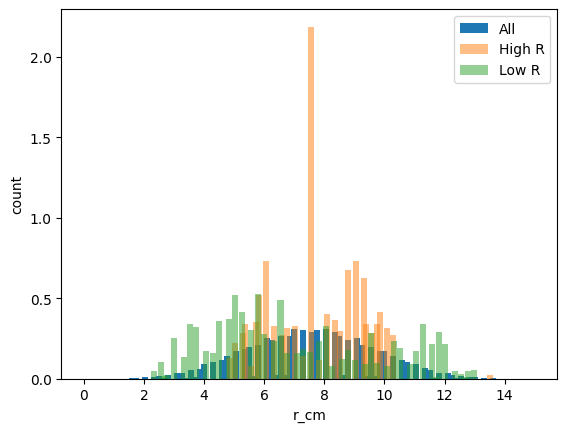

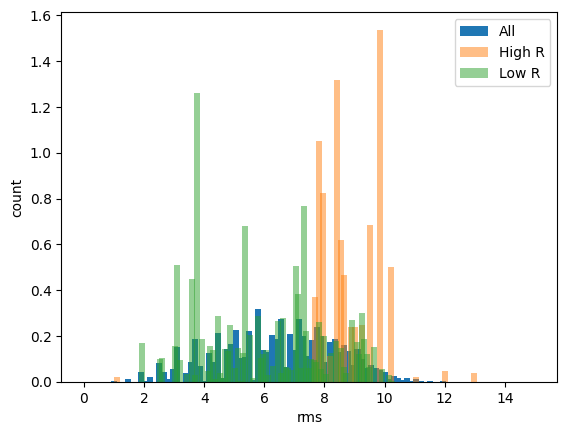

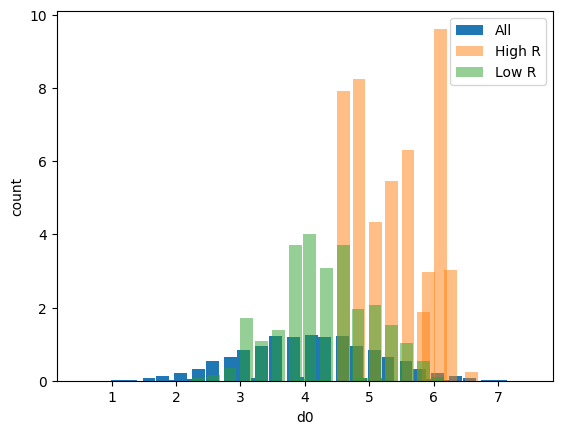

" plt.hist(c_symmetry, bins = 100, density=True, label='All', width=0.2) \nplt.hist(c_sym_800, bins = 100, density=True, label='High R', alpha=0.5, width=0.2) \nplt.hist(c_sym_low, bins = 100, density=True, label='Low R', alpha=0.5, width=0.2) \nplt.xlabel('c_sym')\nplt.ylabel('count')\nplt.legend()\nplt.show() "

In [20]:
# Histograms

bin_edges = np.arange(-0.5,4.5+1,1)
plt.hist([n_subs, n_subs_800, n_subs_low], bins=bin_edges, density=True, label=['All', 'High R', 'Low R'])
plt.xlabel('n_subs')
plt.ylabel('count')
plt.legend()
plt.show()


#plt.hist([r_cm, r_cm_800, r_cm_low], bins=50, density=True, width=0.2, label=['All', 'High R', 'Low R'], alpha=0.7)
plt.hist(r_cm, bins = 100, density=True, label='All', width=0.2) 
plt.hist(r_cm_800, bins = 100, density=True, label='High R', alpha=0.5, width=0.2) 
plt.hist(r_cm_low, bins = 100, density=True, label='Low R', alpha=0.5, width=0.2) 
plt.xlabel('r_cm')
plt.ylabel('count')
plt.legend()
plt.show()


plt.hist(rms, bins = 100, density=True, label='All', width=0.2) 
plt.hist(rms_800, bins = 100, density=True, label='High R', alpha=0.5, width=0.2) 
plt.hist(rms_low, bins = 100, density=True, label='Low R', alpha=0.5, width=0.2) 
plt.xlabel('rms')
plt.ylabel('count')
plt.legend()
plt.show()

plt.hist(d0, bins = 100, density=True, label='All', width=0.2) 
plt.hist(d0_800, bins = 100, density=True, label='High R', alpha=0.5, width=0.2) 
plt.hist(d0_low, bins = 100, density=True, label='Low R', alpha=0.5, width=0.2) 
plt.xlabel('d0')
plt.ylabel('count')
plt.legend()
plt.show()

""" plt.hist(c_symmetry, bins = 100, density=True, label='All', width=0.2) 
plt.hist(c_sym_800, bins = 100, density=True, label='High R', alpha=0.5, width=0.2) 
plt.hist(c_sym_low, bins = 100, density=True, label='Low R', alpha=0.5, width=0.2) 
plt.xlabel('c_sym')
plt.ylabel('count')
plt.legend()
plt.show() """

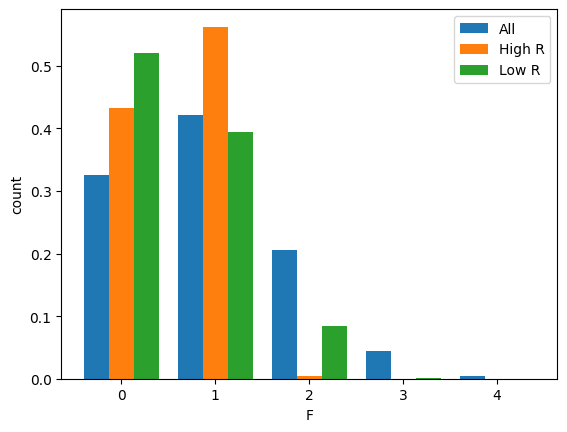

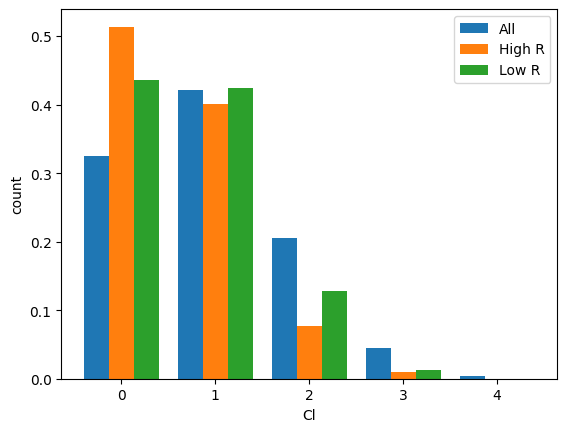

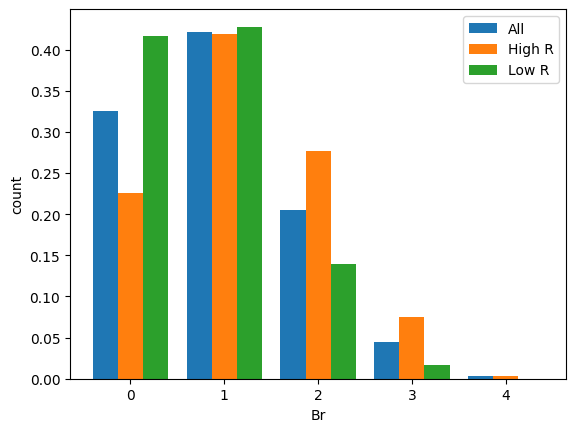

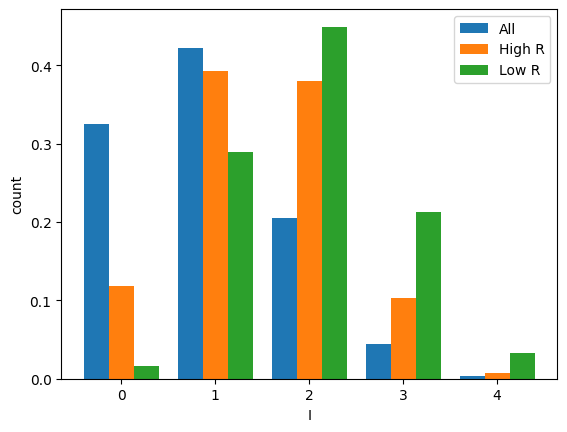

In [21]:
# More Histograms

bin_edges = np.arange(-0.5,4.5+1,1)
plt.hist([n_subs_type[:,1], n_subs_type_800[:,1], n_subs_type_low[:,1]], bins=bin_edges, density=True, label=['All', 'High R', 'Low R'])
plt.xlabel('F')
plt.ylabel('count')
plt.legend()
plt.show()

bin_edges = np.arange(-0.5,4.5+1,1)
plt.hist([n_subs_type[:,2], n_subs_type_800[:,2], n_subs_type_low[:,2]], bins=bin_edges, density=True, label=['All', 'High R', 'Low R'])
plt.xlabel('Cl')
plt.ylabel('count')
plt.legend()
plt.show()

bin_edges = np.arange(-0.5,4.5+1,1)
plt.hist([n_subs_type[:,3], n_subs_type_800[:,3], n_subs_type_low[:,3]], bins=bin_edges, density=True, label=['All', 'High R', 'Low R'])
plt.xlabel('Br')
plt.ylabel('count')
plt.legend()
plt.show()

bin_edges = np.arange(-0.5,4.5+1,1)
plt.hist([n_subs_type[:,4], n_subs_type_800[:,4], n_subs_type_low[:,4]], bins=bin_edges, density=True, label=['All', 'High R', 'Low R'])
plt.xlabel('I')
plt.ylabel('count')
plt.legend()
plt.show()

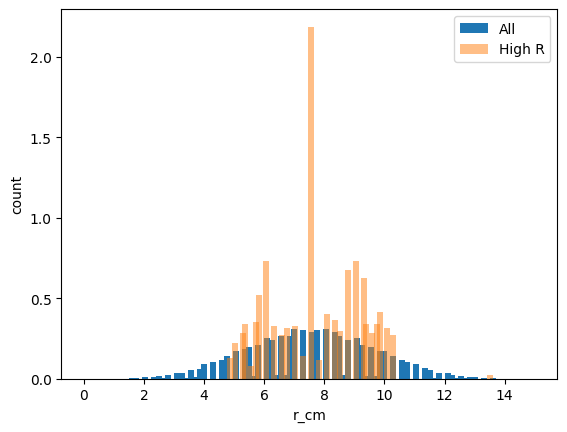

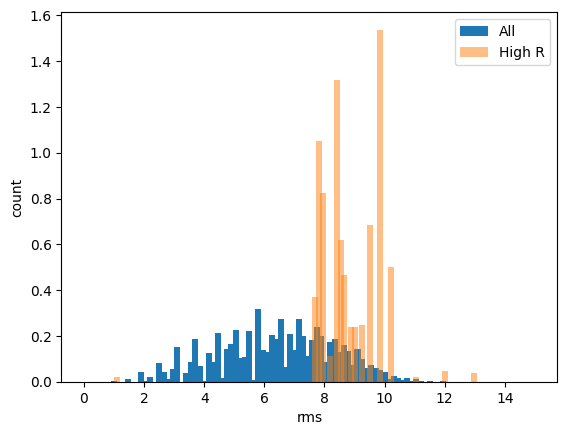

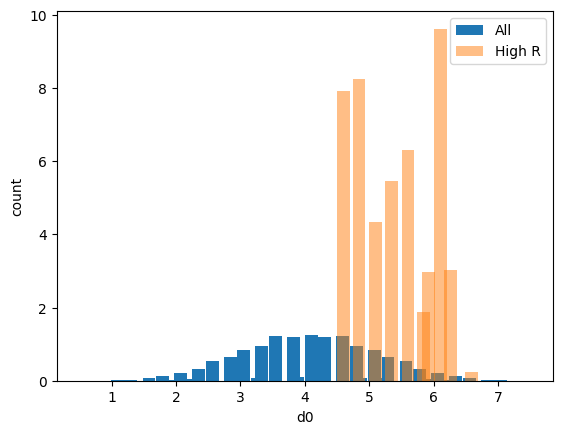

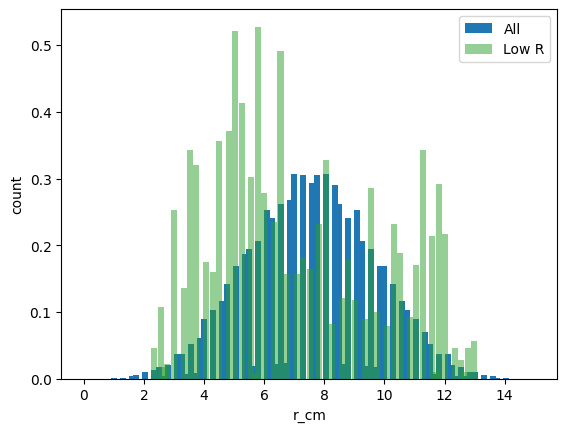

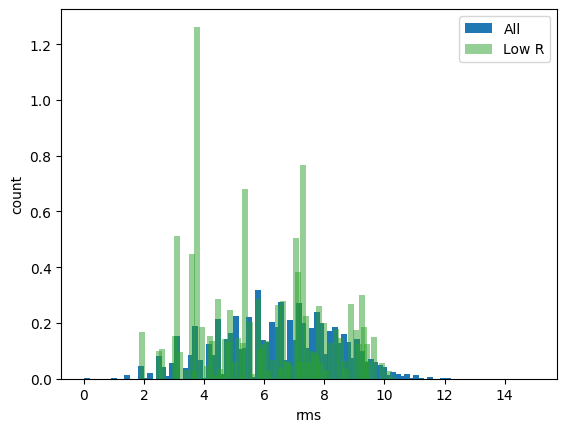

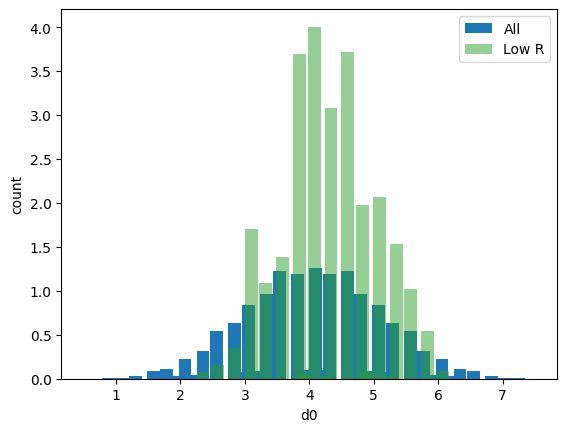

In [23]:
#plt.hist([r_cm, r_cm_800, r_cm_low], bins=50, density=True, width=0.2, label=['All', 'High R', 'Low R'], alpha=0.7)
plt.hist(r_cm, bins = 100, density=True, label='All', width=0.2) 
plt.hist(r_cm_800, bins = 100, density=True, label='High R', alpha=0.5, width=0.2) 
plt.xlabel('r_cm')
plt.ylabel('count')
plt.legend()
plt.show()


plt.hist(rms, bins = 100, density=True, label='All', width=0.2) 
plt.hist(rms_800, bins = 100, density=True, label='High R', alpha=0.5, width=0.2) 
plt.xlabel('rms')
plt.ylabel('count')
plt.legend()
plt.show()

plt.hist(d0, bins = 100, density=True, label='All', width=0.2) 
plt.hist(d0_800, bins = 100, density=True, label='High R', alpha=0.5, width=0.2) 
plt.xlabel('d0')
plt.ylabel('count')
plt.legend()
plt.show()

plt.hist(r_cm, bins = 100, density=True, label='All', width=0.2) 
#plt.hist(r_cm_800, bins = 100, density=True, label='High R', alpha=0.5, width=0.2) 
plt.hist(r_cm_low, bins = 100, density=True, label='Low R', alpha=0.5, width=0.2,color='tab:green') 
plt.xlabel('r_cm')
plt.ylabel('count')
plt.legend()
plt.show()


plt.hist(rms, bins = 100, density=True, label='All', width=0.2) 
#plt.hist(rms_800, bins = 100, density=True, label='High R', alpha=0.5, width=0.2) 
plt.hist(rms_low, bins = 100, density=True, label='Low R', alpha=0.5, width=0.2, color='tab:green') 
plt.xlabel('rms')
plt.ylabel('count')
plt.legend()
plt.show()

plt.hist(d0, bins = 100, density=True, label='All', width=0.2) 
#plt.hist(d0_800, bins = 100, density=True, label='High R', alpha=0.5, width=0.2) 
plt.hist(d0_low, bins = 100, density=True, label='Low R', alpha=0.5, width=0.2,color='tab:green') 
plt.xlabel('d0')
plt.ylabel('count')
plt.legend()
plt.show()

In [24]:
file = open('R_high_non_linear.txt','w')
for i in range(x_data_800.shape[0]):
    #file.write(str(x_data_800[i,:])+'  '+str(round(R_pred_800[i],2))+'\n')
    file.write(str(int_to_str(x_data_800[i,:]))+'  '+str(round(R_pred_800[i],2))+'\n')
file.close()

file = open('R_low_non_linear.txt','w')
for i in range(x_data_low.shape[0]):
    #file.write(str(x_data_low[i,:])+'  '+str(round(R_pred_low[i],2))+'\n')
    file.write(str(int_to_str(x_data_low[i,:]))+'  '+str(round(R_pred_low[i],2))+'\n')
file.close()

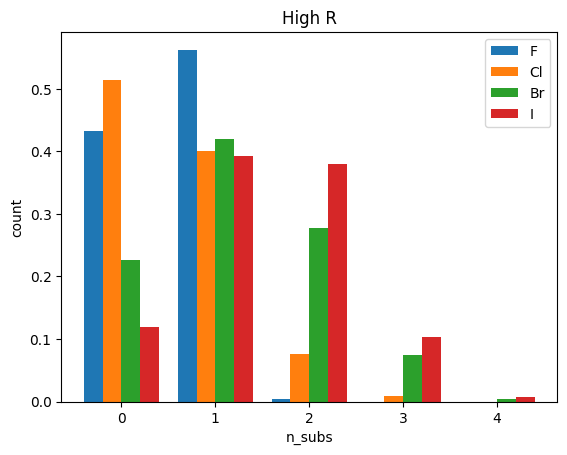

([<matplotlib.axis.XTick at 0x7ff1e410dea0>,
 [Text(1, 0, 'F'), Text(2, 0, 'Cl'), Text(3, 0, 'Br'), Text(4, 0, 'I')])

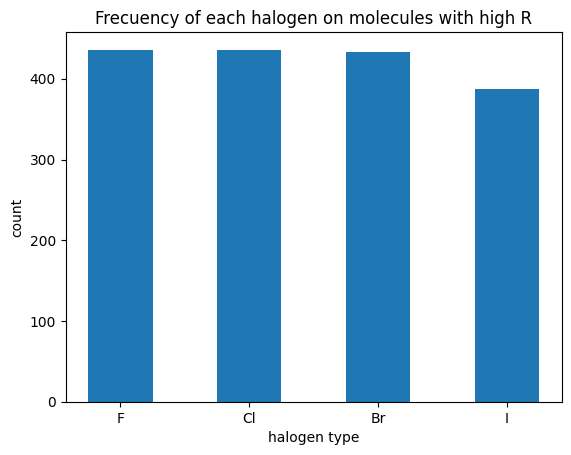

In [25]:
# Look halogen type

bin_edges = np.arange(-0.5,4.5+1,1)
plt.hist(n_subs_type_800[:,1:], bins=bin_edges, density=True, label=['F','Cl','Br','I'])
plt.title('High R')
plt.xlabel('n_subs')
plt.ylabel('count')
plt.legend()
plt.show()

# Compute number of data with each specific halogen
n_halo = np.zeros(4)
for i in range(x_data_800.shape[0]):
    for j in range(4):
        n_halo[j] = n_halo[j] + n_subs_type[i,j+1]

plt.bar([1,2,3,4],n_halo, width=0.5)
plt.title('Frecuency of each halogen on molecules with high R')
plt.xlabel('halogen type')
plt.ylabel('count')
plt.xticks(np.arange(1,4+1), ['F', 'Cl', 'Br', 'I'])
#plt.xticks(['F', 'Cl', 'Br', 'I'])
#plt.xticks('F,Cl,Br,I')

(878, 16)


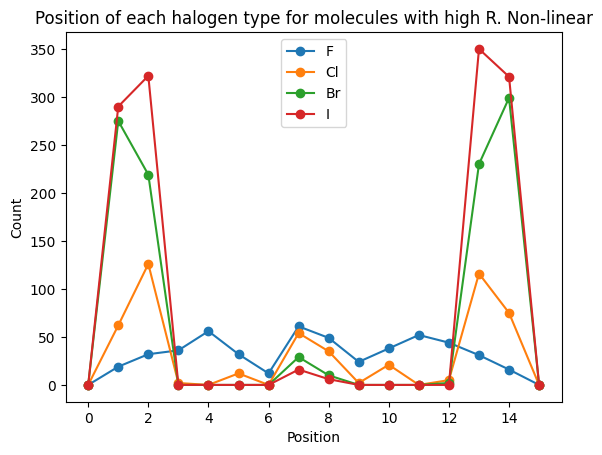

In [38]:
# Position of halogens for high R

print(x_data_800.shape)

n_halo_pos = np.zeros((16,4))
for i in range(x_data_800.shape[0]):
    for j in range(n_pos):
        if (x_data_800[i,j]>0):    
            htype = int(x_data_800[i,j])
            n_halo_pos[j,htype-1] = n_halo_pos[j,htype-1] + 1
frecuency_F = n_halo_pos[:,0]
frecuency_Cl = n_halo_pos[:,1]
frecuency_Br = n_halo_pos[:,2]
frecuency_I = n_halo_pos[:,3]

plt.title('Position of each halogen type for molecules with high R. Non-linear')
plt.plot(np.arange(16),frecuency_F,'-o',label='F')
plt.plot(np.arange(16),frecuency_Cl,'-o',label='Cl')
plt.plot(np.arange(16),frecuency_Br,'-o',label='Br')
plt.plot(np.arange(16),frecuency_I,'-o',label='I')
plt.xlabel('Position')
plt.ylabel('Count')
plt.legend()
plt.show()


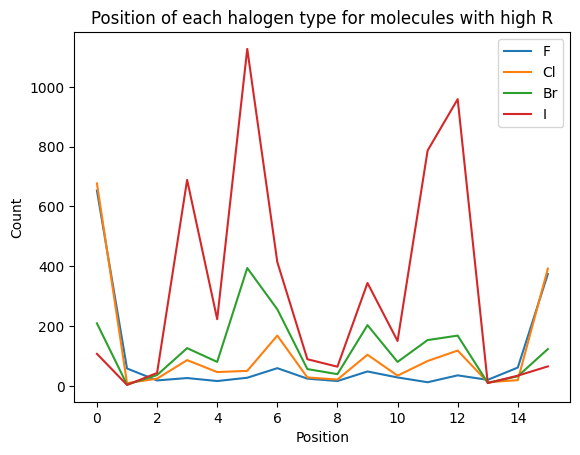

In [29]:
""" # Position of halogens for low R

#print(x_data_800.shape)

n_halo_pos = np.zeros((16,4))
for i in range(x_data_low.shape[0]):
    for j in range(n_pos):
        if (x_data_low[i,j]>0):    
            htype = int(x_data_low[i,j])
            n_halo_pos[j,htype-1] = n_halo_pos[j,htype-1] + 1
frecuency_F = n_halo_pos[:,0]
frecuency_Cl = n_halo_pos[:,1]
frecuency_Br = n_halo_pos[:,2]
frecuency_I = n_halo_pos[:,3]

plt.title('Position of each halogen type for molecules with high R')
plt.plot(np.arange(16),frecuency_F,label='F')
plt.plot(np.arange(16),frecuency_Cl,label='Cl')
plt.plot(np.arange(16),frecuency_Br,label='Br')
plt.plot(np.arange(16),frecuency_I,label='I')
plt.xlabel('Position')
plt.ylabel('Count')
plt.legend()
plt.show() """

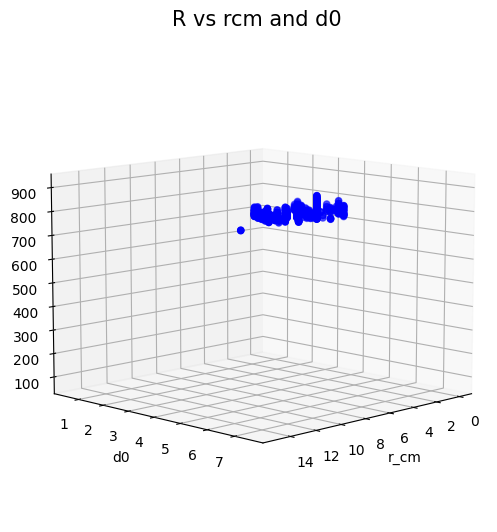

In [30]:
# 3D plot of R vs r_cm and d0
#import PyQt5
#%matplotlib qt
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

x_800,y_800,z_800 = r_cm_800, d0_800, R_pred_800
x_all,y_all,z_all = r_cm, d0, R_pred
fig = plt.figure( figsize=(9,6) )
ax = fig.add_subplot(projection='3d')
ax.scatter(x_all, y_all, z_all, color='grey',alpha=0.001)
ax.scatter(x_800, y_800, z_800, color='blue')
ax.set_title('R vs rcm and d0',pad=25,size=15)
ax.set_xlabel("r_cm") 
ax.set_ylabel("d0") 
ax.set_zlabel("R")

ax.azim = 45
ax.elev = 10

plt.show()

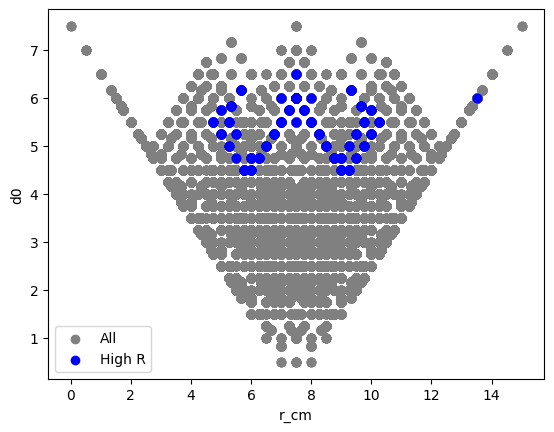

In [31]:
# 2D scatter plot

x_800,y_800 = r_cm_800, d0_800
x_all,y_all = r_cm, d0

plt.scatter(x_all, y_all, color='grey',label='All')
plt.scatter(x_800, y_800, color='blue',label='High R')
#plt.title('R vs rcm and d0',pad=25,size=15)
plt.xlabel("r_cm") 
plt.ylabel("d0") 
plt.legend()
plt.show()

Text(0, 0.5, 'R_pred')

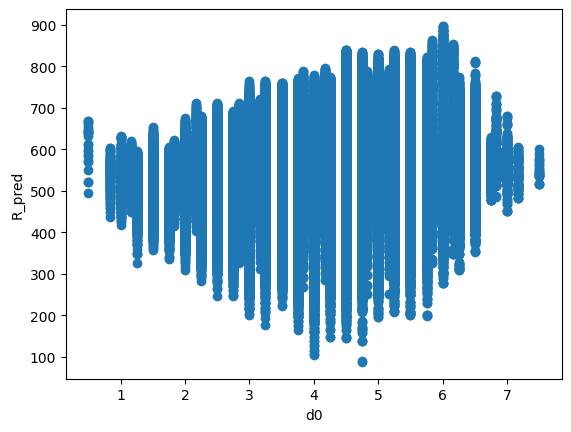

In [32]:
# Plot R vs d0

plt.scatter(d0,R_pred)
plt.xlabel('d0')
plt.ylabel('R_pred')

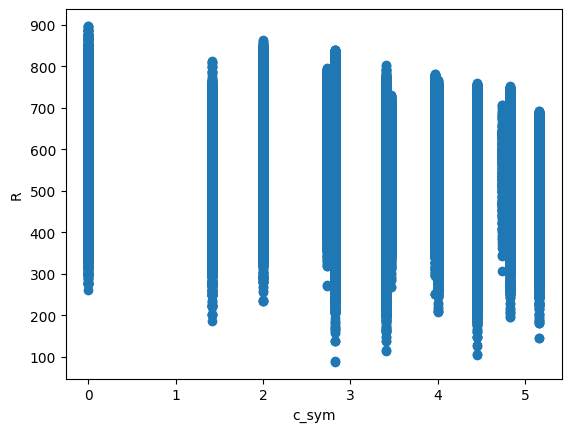

In [33]:
# Plot R vs c_sym

plt.scatter(c_symmetry,R_pred)
plt.xlabel('c_sym')
plt.ylabel('R')
plt.show()

Text(0, 0.5, 'R_pred')

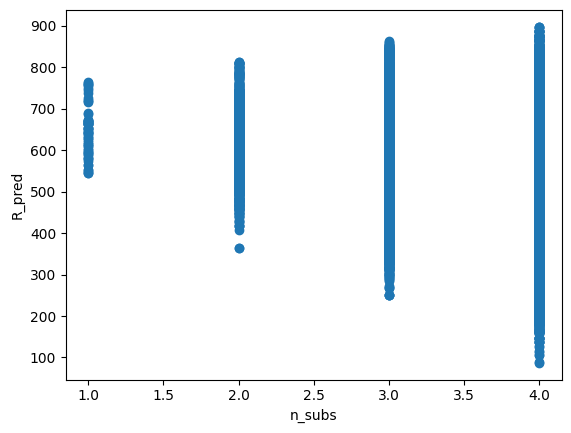

In [34]:
# Plot R vs n_subs

plt.scatter(n_subs,R_pred)
plt.xlabel('n_subs')
plt.ylabel('R_pred')

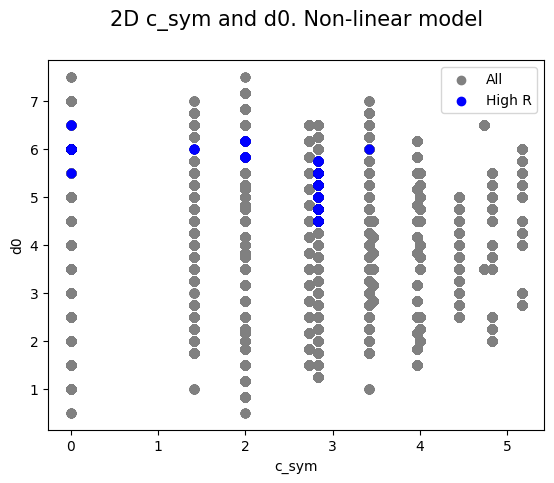

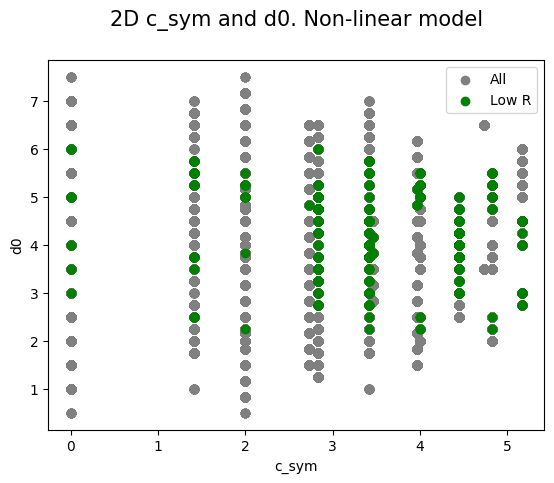

In [37]:
# 2D scatter plot of d0 and c_sym

x_800,y_800 = c_sym_800, d0_800
x_all,y_all = c_symmetry, d0
x_low,y_low = c_sym_low, d0_low

plt.scatter(x_all, y_all, color='grey',label='All')
plt.scatter(x_800, y_800, color='blue',label='High R')
#plt.scatter(x_low, y_low, color='green',label='Low R')
plt.title('2D c_sym and d0. Non-linear model',pad=25,size=15)
plt.xlabel("c_sym") 
plt.ylabel("d0") 
plt.legend()
plt.show()

x_800,y_800 = c_sym_800, d0_800
x_all,y_all = c_symmetry, d0
x_low,y_low = c_sym_low, d0_low

plt.scatter(x_all, y_all, color='grey',label='All')
#plt.scatter(x_800, y_800, color='blue',label='High R')
plt.scatter(x_low, y_low, color='green',label='Low R')
plt.title('2D c_sym and d0. Non-linear model',pad=25,size=15)
plt.xlabel("c_sym") 
plt.ylabel("d0") 
plt.legend()
plt.show()


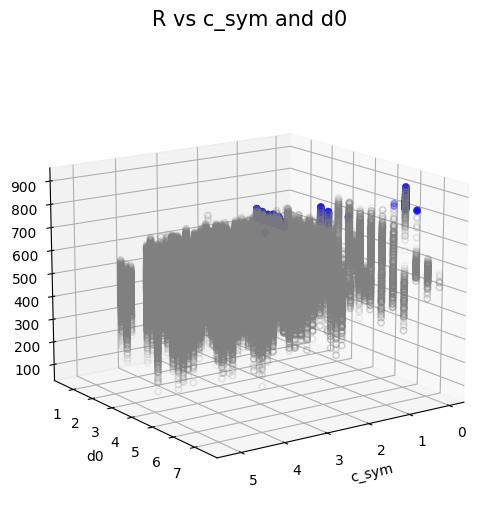

In [36]:
# 3D plot of R vs c_sym and d0
#import PyQt5
#%matplotlib qt
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

x_800,y_800,z_800 = c_sym_800, d0_800, R_pred_800
x_all,y_all,z_all = c_symmetry, d0, R_pred
fig = plt.figure( figsize=(9,6) )
ax = fig.add_subplot(projection='3d')
#ax.scatter(x_all, y_all, z_all, color='grey',alpha=0.1)
ax.scatter(x_all, y_all, z_all, facecolors='none', edgecolors='grey',alpha=0.1)
ax.scatter(x_800, y_800, z_800, color='blue')

#ax.plot(x_800, y_800, 'b+', zdir='z', zs=-1.5)
#h, xedges, yedges = np.histogram2d(x_all, y_all, bins=50)
#h = h.transpose()
#normalized_map = plt.cm.Blues(h/h.max())
#xx, yy = np.meshgrid(xedges, yedges)
#zpos = min(z_all)-2 # Plane of histogram
#zflat = np.full_like(xx, zpos) 
#ax.plot_surface(zflat, xx, yy, facecolors=normalized_map, rstride=1, cstride=1, shade=False)

ax.set_title('R vs c_sym and d0',pad=25,size=15)
ax.set_xlabel("c_sym") 
ax.set_ylabel("d0") 
ax.set_zlabel("R")

#ax.azim = 45
ax.azim = 55
ax.elev = 15

plt.show()